<a href="https://colab.research.google.com/github/Anirudh-R-1201/Football_xG/blob/master/FeatureEngineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
from IPython.display import display
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing, model_selection, metrics
from sklearn.model_selection import StratifiedKFold, cross_val_score
from collections import defaultdict
import matplotlib.pyplot as plt
!pip install rfpimp
from rfpimp import *
import scipy
from scipy.cluster import hierarchy as hc
%reload_ext autoreload
%autoreload 2
%matplotlib inline

  Created wheel for rfpimp: filename=rfpimp-1.3.6-cp36-none-any.whl size=10645 sha256=3e9705a12c68171a58e8ceb534a4ce19641f7b76a52b6626858aef92c0c8c33b
  Stored in directory: /root/.cache/pip/wheels/4d/dc/d3/cf941c8f72eb5f1864506a1a6ddd689729063798292e539522
Successfully built rfpimp


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
from google.colab import files  
files.upload()

Saving shots.csv to shots.csv


{'shots.csv': b'duration,pass_aerial_won,pass_angle,pass_body_part_name,pass_cross,pass_cut_back,pass_deflected,pass_height_name,pass_length,pass_switch,pass_through_ball,play_pattern_name,shot_aerial_won,shot_body_part_name,shot_first_time,shot_one_on_one,shot_open_goal,shot_technique_name,under_pressure,goal,distance,angle,build_up_duration,direct_free_kick,shot_cone,num_players_in_shot_cone,distance_to_nearest_opponent,pass_angle_na,pass_length_na,distance_to_nearest_opponent_na\n1.301567,0,0.0,,0,0,0,,0.0,0,0,From Free Kick,0,other,0,0,0,Normal,0,0,28.66810073932349,0.4745676117403513,19.779432999999997,1,102.0,0,16.890825912311097,True,True,False\n0.054247,0,0.0,,0,0,0,,0.0,0,0,From Free Kick,0,other,1,0,0,Normal,0,0,21.019038988498018,0.4636476090008061,1.717753,1,75.19999999999982,0,10.43934863868431,True,True,False\n0.160234,0,0.0,,0,0,0,,0.0,0,0,From Free Kick,0,other,0,0,0,Normal,1,0,16.807736313971606,0.24642166356830222,5.599766,1,65.19999999999982,0,3.3955853692699254,True

In [5]:
shots = pd.read_csv('shots.csv')
shots.head

<bound method NDFrame.head of       duration  ...  distance_to_nearest_opponent_na
0     1.301567  ...                            False
1     0.054247  ...                            False
2     0.160234  ...                            False
3     0.383183  ...                            False
4     0.280194  ...                            False
...        ...  ...                              ...
1661  1.293000  ...                            False
1662  0.400000  ...                            False
1663  0.920000  ...                            False
1664  0.973000  ...                            False
1665  0.960000  ...                            False

[1666 rows x 30 columns]>

In [7]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000): 
        with pd.option_context("display.max_columns", 1000): 
            display(df.head().transpose())

In [8]:
features = shots.drop('goal', axis=1)
labels = shots['goal']
cont_cols = ['duration', 'build_up_duration', 'pass_angle', 'pass_length', 'distance', 
             'angle', 'shot_cone', 'distance_to_nearest_opponent']

cat_features = features.drop(cont_cols, axis=1)
cont_features = features[cont_cols]

def label_encode(df):
    df_le = pd.DataFrame({col: df[col].astype('category').cat.codes for col in df}, index=df.index)
    mappings = {col: {n: cat for n, cat in enumerate(df[col].astype('category').cat.categories)} 
     for col in df}
    return df_le, mappings

cat_features_le, mappings = label_encode(cat_features)

features_le = cont_features.merge(cat_features_le, left_index=True, right_index=True)
display_all(features_le)

,0,1,2,3,4
duration,1.301567,0.054247,0.160234,0.383183,0.280194
build_up_duration,19.779433,1.717753,5.599766,16.036817,5.719806
pass_angle,0.000000,0.000000,0.000000,0.000000,0.000000
pass_length,0.000000,0.000000,0.000000,0.000000,0.000000
distance,28.668101,21.019039,16.807736,20.470711,13.535139
angle,0.474568,0.463648,0.246422,0.844154,0.596199
shot_cone,102.000000,75.200000,65.200000,54.400000,44.800000
distance_to_nearest_opponent,16.890826,10.439349,3.395585,7.731753,3.104835
pass_aerial_won,0.000000,0.000000,0.000000,0.000000,0.000000
pass_body_part_name,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000


In [9]:
X = features_le
y = labels

m = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def get_loss(X, y=y, m=m, cv=cv):
    scores = cross_val_score(m, X, y, cv=cv, scoring='brier_score_loss')
    return np.mean(scores)*-1

loss = get_loss(X=X)
print('Brier loss:', "{0:.5f}".format(loss))

Brier loss: 0.06956


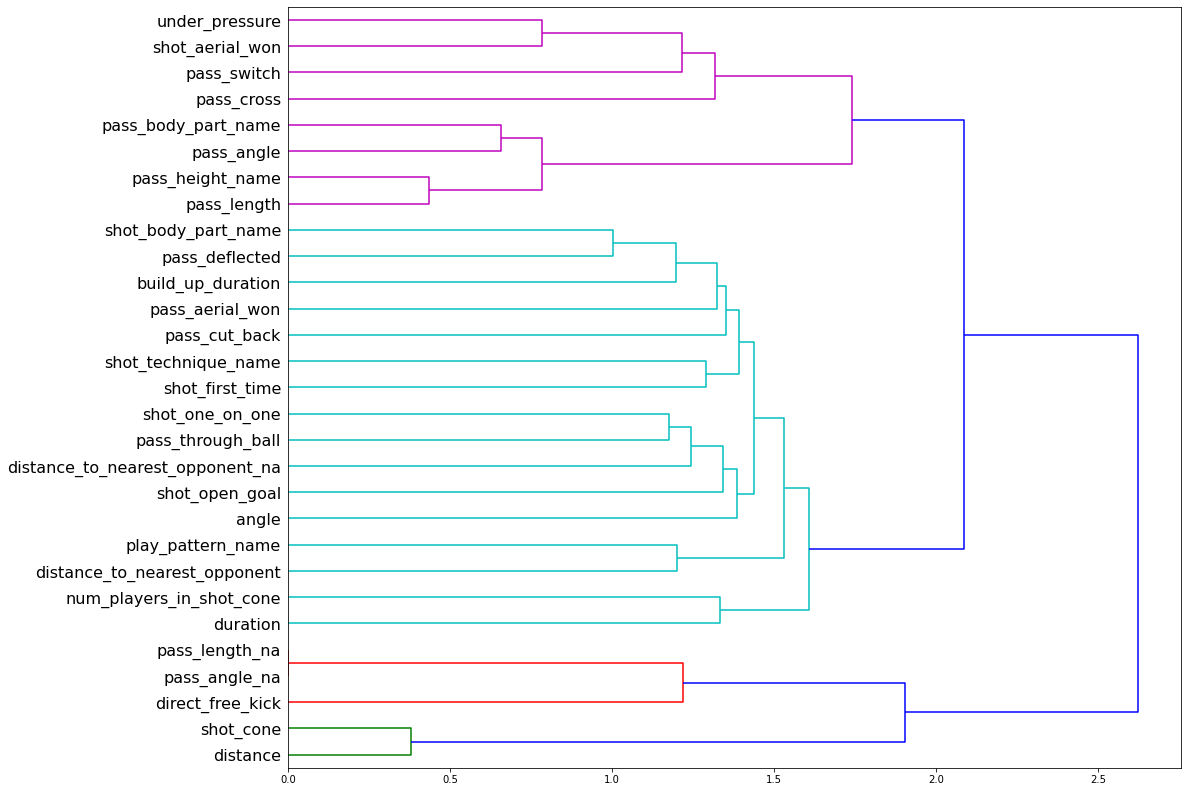

In [97]:
def dendrogram(X):
    #print(X.shape)
    corr = np.round(scipy.stats.spearmanr(X).correlation, 4)#scipy.stats.spearmanr(X).correlation
    corr = np.nan_to_num(corr)
    #corr = np.fill_diagonal(corr,0.0)
    #corr_condensed = hc.distance.squareform(1-corr)
    z = hc.linkage(corr, method='average')
    fig = plt.figure(figsize=(16,14))
    dendrogram = hc.dendrogram(z, labels=X.columns, 
         orientation='right', leaf_font_size=16)
    plt.show()
    return

dendrogram(X)

In [99]:
feats = ['shot_cone', 'distance', 'under_pressure' , 'pass_deflected', 'shot_body_part_name',
         ['pass_angle_na', 'pass_length_na'],'shot_aerial_won',
         'pass_height_name', 'pass_body_part_name', 'pass_length', 'pass_angle']

print('original', "{0:.5f}".format(loss))
for feat in feats:
    loss_feats = get_loss(X=X.drop(feat, axis=1))   
    print(feat, "{0:.5f}".format(loss_feats))

original 0.06956
shot_cone 0.06967
distance 0.07034
under_pressure 0.06962
pass_deflected 0.06912
shot_body_part_name 0.06891
['pass_angle_na', 'pass_length_na'] 0.06863
shot_aerial_won 0.06922
pass_height_name 0.06936
pass_body_part_name 0.06881
pass_length 0.06932
pass_angle 0.06903


In [100]:
X1 = X.drop(['shot_cone',  'pass_body_part_name','pass_deflected', 'shot_aerial_won', 'pass_angle', 
             'pass_length', 'pass_length_na'], axis=1)

loss1 = get_loss(X=X1)
print('Brier loss:', "{0:.5f}".format(loss1))

Brier loss: 0.06884


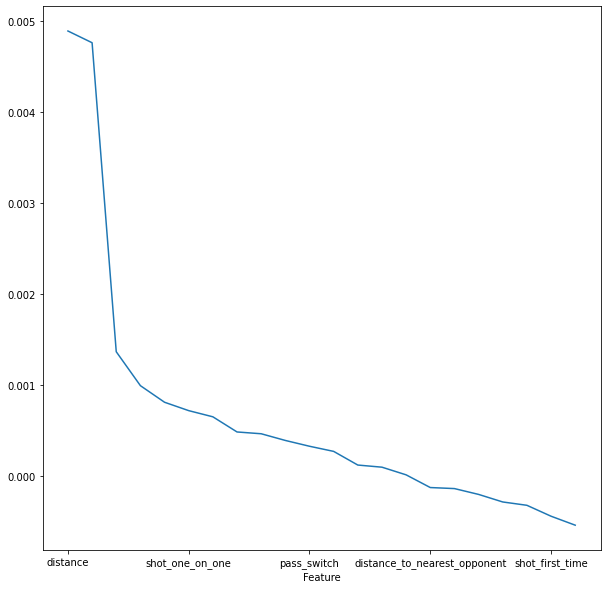

In [102]:
def get_imp(X, y=y, m=m, cv=cv):
    baseline = get_loss(X=X, y=y, m=m, cv=cv)
    imp = []
    for col in X.columns:
        s = get_loss(X=X.drop(col, axis=1), y=y, m=m, cv=cv)
        change_in_score = s - baseline
        imp.append(change_in_score)
    imp_df = pd.DataFrame(data={'Feature': X.columns, 'Importance': np.array(imp)})
    imp_df = imp_df.set_index('Feature').sort_values('Importance', ascending=False)
    return imp_df

imp1 = get_imp(X=X1)
imp1.reset_index().plot('Feature', 'Importance', figsize=(10,10), legend=False);

In [103]:
def elim_feats(X, imp, thresh):
    return X[list(imp[imp.values>thresh].index.values)]

thresholds = [float(x) for x in np.linspace(start=0.0, stop=0.0005, num=10)]

print('Original Brier loss:', "{0:.5f}".format(loss1))
for thresh in thresholds:
    X_elim = elim_feats(X=X1, imp=imp1, thresh=thresh)
    loss_elim = get_loss(X=X_elim)
    print('Threshold:', "{0:.5f}".format(thresh), 'Brier loss:', "{0:.5f}".format(loss_elim))

Original Brier loss: 0.06884
Threshold: 0.00000 Brier loss: 0.06841
Threshold: 0.00006 Brier loss: 0.06866
Threshold: 0.00011 Brier loss: 0.06935
Threshold: 0.00017 Brier loss: 0.07027
Threshold: 0.00022 Brier loss: 0.07027
Threshold: 0.00028 Brier loss: 0.06988
Threshold: 0.00033 Brier loss: 0.06959
Threshold: 0.00039 Brier loss: 0.06959
Threshold: 0.00044 Brier loss: 0.06973
Threshold: 0.00050 Brier loss: 0.07290


Brier loss: 0.06866


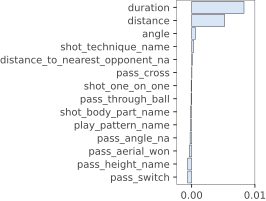

In [104]:
X2 = elim_feats(X=X1, imp=imp1, thresh=0.00006)

loss2 = get_loss(X=X2)
imp2 = get_imp(X=X2)
print('Brier loss:', "{0:.5f}".format(loss2))
plot_importances(imp2, imp_range=(min(imp2.values), max(imp2.values)))

In [105]:
print(mappings['shot_technique_name'])

{0: 'Backheel', 1: 'Diving Header', 2: 'Half Volley', 3: 'Lob', 4: 'Normal', 5: 'Overhead Kick', 6: 'Volley'}


In [106]:
pd.get_dummies(X2['shot_technique_name'], prefix='shot_technique').head()

,shot_technique_0,shot_technique_1,shot_technique_2,shot_technique_3,shot_technique_4,shot_technique_5,shot_technique_6
0,0,0,0,0,1,0,0
1,0,0,0,0,1,0,0
2,0,0,0,0,1,0,0
3,0,0,0,0,1,0,0
4,0,0,0,0,1,0,0


In [107]:
one_hot = ['shot_technique_name']

for feat in one_hot:
    X_one_hot = pd.concat([X2, pd.get_dummies(X2[feat], prefix=feat)], axis=1)
    X_one_hot.drop(feat, axis=1, inplace=True)
    loss_one_hot = get_loss(X=X_one_hot)   
    print(feat, "{0:.5f}".format(loss_one_hot))

shot_technique_name 0.06820


Brier loss: 0.06820


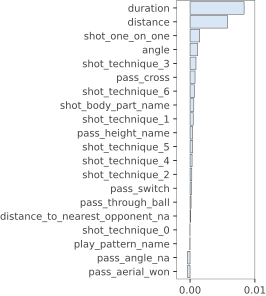

In [108]:
X3 = pd.concat([X2, pd.get_dummies(X2['shot_technique_name'], prefix='shot_technique')], axis=1)
X3.drop('shot_technique_name', axis=1, inplace=True)

loss3 = get_loss(X=X3)
imp3 = get_imp(X=X3)
print('Brier loss:', "{0:.5f}".format(loss3))
plot_importances(imp3, imp_range=(min(imp3.values), max(imp3.values)))

Brier loss: 0.06815


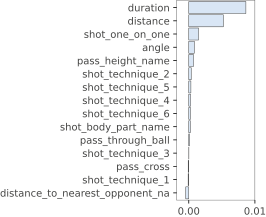

In [109]:
X4 = elim_feats(X=X3, imp=imp3, thresh=0)
X4 = X4.drop('pass_switch', axis=1)

loss4 = get_loss(X=X4)
imp4 = get_imp(X=X4)
print('Brier loss:', "{0:.5f}".format(loss4))
plot_importances(imp4, imp_range=(min(imp4.values), max(imp4.values)))

Brier loss: 0.06803


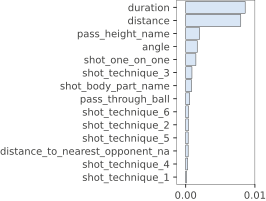

In [110]:
X4 = X4.drop('pass_cross', axis = 1)
loss4 = get_loss(X=X4)
imp4 = get_imp(X=X4)
print('Brier loss:', "{0:.5f}".format(loss4))
plot_importances(imp4, imp_range=(min(imp4.values), max(imp4.values)))

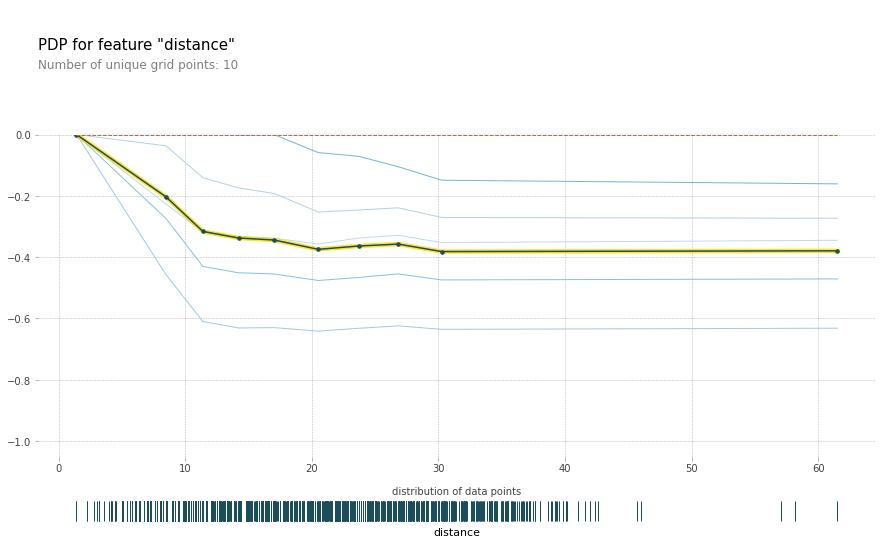

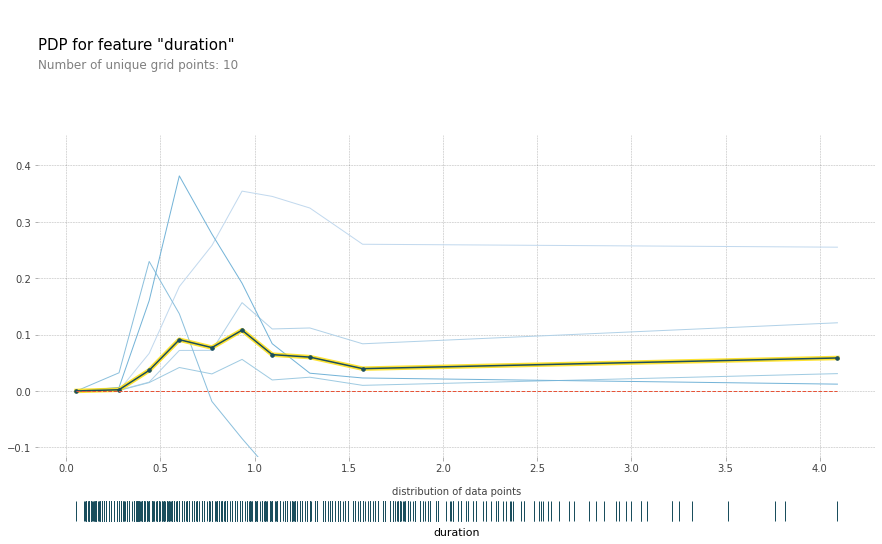

In [111]:
!pip install pdpbox
from pdpbox import pdp 
def plot_pdp(X, feat, model=m, clusters=5, feat_name=None, y=y):
    m.fit(X, y)
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(model=m, dataset=X, model_features=X.columns, feature=feat)
    fig, ax = pdp.pdp_plot(p, feat_name, plot_lines=True, plot_pts_dist=True, 
                           cluster=clusters is not None, n_cluster_centers=clusters);
    return

plot_pdp(X=X4, feat='distance')
plot_pdp(X=X4, feat='duration')

In [112]:
data = X4.join(y)
data.to_csv('data.csv')
files.download('data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>